In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [74]:
import warnings
warnings.filterwarnings("ignore")

In [75]:
airlines = pd.read_csv("US_carrier.csv")

In [76]:
airlines.head()

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,RAMP_TO_RAMP,AIR_TIME,...,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH,CLASS
0,0,11,383600,0,0,33915,4598,571,1149,928,...,JNU,"Juneau, AK",AK,ANC,"Anchorage, AK",AK,2010,1,2,G
1,0,1,12500,50,46,0,0,507,115,89,...,CVG,"Cincinnati, OH",KY,PHL,"Philadelphia, PA",PA,2010,1,2,F
2,0,1,12500,50,46,0,0,501,121,88,...,RDU,"Raleigh/Durham, NC",NC,DTW,"Detroit, MI",MI,2010,1,2,F
3,0,14,746000,25,0,221471,0,507,1503,1069,...,CVG,"Cincinnati, OH",KY,PHL,"Philadelphia, PA",PA,2010,1,2,P
4,0,56,67200,336,109,4,194,40,1379,1267,...,EEK,"Eek, AK",AK,BET,"Bethel, AK",AK,2010,1,3,F


In [77]:
airlines.shape

(3840585, 23)

In [78]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840585 entries, 0 to 3840584
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   DEPARTURES_SCHEDULED  int64  
 1   DEPARTURES_PERFORMED  int64  
 2   PAYLOAD               int64  
 3   SEATS                 int64  
 4   PASSENGERS            int64  
 5   FREIGHT               int64  
 6   MAIL                  int64  
 7   DISTANCE              int64  
 8   RAMP_TO_RAMP          int64  
 9   AIR_TIME              int64  
 10  UNIQUE_CARRIER        object 
 11  CARRIER_NAME          object 
 12  CARRIER_GROUP_NEW     float64
 13  ORIGIN                object 
 14  ORIGIN_CITY_NAME      object 
 15  ORIGIN_STATE_ABR      object 
 16  DEST                  object 
 17  DEST_CITY_NAME        object 
 18  DEST_STATE_ABR        object 
 19  YEAR                  int64  
 20  QUARTER               int64  
 21  MONTH                 int64  
 22  CLASS                 object 
dtypes: floa

### Forecast

In [79]:
passengers = airlines.loc[:,['YEAR','MONTH','PASSENGERS', 'ORIGIN']]

In [80]:
# Choose the SFO airport as the departure airport
pass_sfo = passengers.loc[passengers['ORIGIN'] == 'SFO']

In [81]:
pass_sfo.drop(['ORIGIN'], axis = 1,inplace = True)

In [82]:
pass_sfo

,YEAR,MONTH,PASSENGERS
285,2010,9,150
295,2010,9,16
1435,2010,4,99
1557,2010,11,168
2433,2010,4,0
...,...,...,...
3840104,2020,2,14331
3840146,2020,3,7559
3840328,2020,7,8342
3840455,2020,8,8929


In [83]:
pass_sfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47229 entries, 285 to 3840512
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   YEAR        47229 non-null  int64
 1   MONTH       47229 non-null  int64
 2   PASSENGERS  47229 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [84]:
# combine year, month together
pass_sfo['DATE'] = pd.to_datetime(dict(year = pass_sfo['YEAR'], month = pass_sfo['MONTH'], day = 1))

In [85]:
pass_sfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47229 entries, 285 to 3840512
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   YEAR        47229 non-null  int64         
 1   MONTH       47229 non-null  int64         
 2   PASSENGERS  47229 non-null  int64         
 3   DATE        47229 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.8 MB


In [86]:
pass_sfo.head()

,YEAR,MONTH,PASSENGERS,DATE
285,2010,9,150,2010-09-01
295,2010,9,16,2010-09-01
1435,2010,4,99,2010-04-01
1557,2010,11,168,2010-11-01
2433,2010,4,0,2010-04-01


In [87]:
pass_sfo.drop(['YEAR', 'MONTH'], axis = 1, inplace = True)

In [88]:
pass_sfo = pass_sfo.groupby('DATE').sum()

In [89]:
pass_sfo.tail(12)

,PASSENGERS
DATE,
2019-10-01,1734860
2019-11-01,1600886
2019-12-01,1701128
2020-01-01,1433758
2020-02-01,1383078
2020-03-01,669321
2020-04-01,46882
2020-05-01,117290
2020-06-01,241624


### 2. Visualize the data

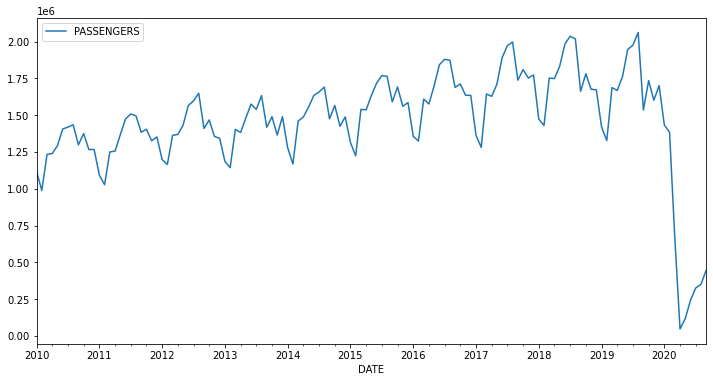

In [90]:
pass_sfo.plot()

**Due to Covid, the airline passengers dropped drastically in the March, 2020, the forecast model can't predict this abnormal incident. For practice purpose, I will use year 2010-2018 data to predict passengers demand for year 2019, and compare with the real data to see the accuracy of the forecast model.**

In [91]:
# remove the last 9 rows from the dataset
pass_sfo_19 = pass_sfo.iloc[0:(len(pass_sfo)-9)]

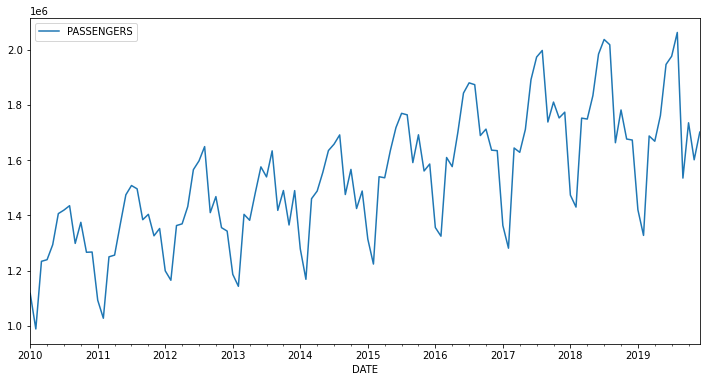

In [92]:
# Plot the data from 2010-2018
pass_sfo_19.plot()

#### Decomposition

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [94]:
result = seasonal_decompose(pass_sfo_19['PASSENGERS'], model = 'add')

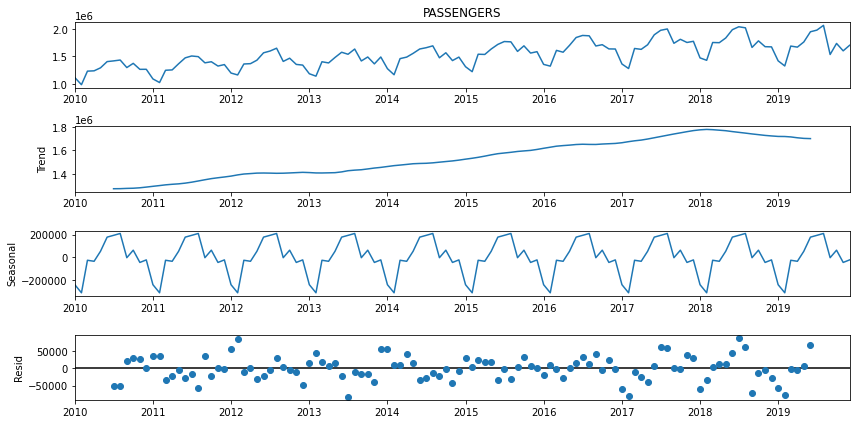

In [95]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,6

result.plot();

It is obivous that the data has trend and seasonality.

### 3. Auto ARIMA

In [96]:
from pmdarima import auto_arima

In [97]:
# Fit auto_arima() function and let the model find the best p, d, q, P,D,Q parameter

stepwise_fit = auto_arima(pass_sfo_19['PASSENGERS'], start_p = 0, start_q = 0, max_p = 6, max_q = 6,
           seasonal = True, m = 12,trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=2702.794, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2698.796, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2755.031, Time=0.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2696.108, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2744.835, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=2694.461, Time=0.06 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=2696.110, Time=0.16 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=2698.108, Time=0.28 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=2696.563, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2753.780, Time=0.06 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=2732.558, Time=0.31 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=2728.930, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,1,0)[12] intercept
Total fit time: 1.894 seconds


In [98]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  120
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood               -1344.231
Date:                             Wed, 15 Dec 2021   AIC                           2694.461
Time:                                     16:00:54   BIC                           2702.508
Sample:                                          0   HQIC                          2697.724
                                             - 120                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.625e+04   6928.195      6.676      0.000    3.27e+04    5.98e+04
ma.L1          0.1217      0.020      6.234      0.000       0.083       0.160
sigma2      3.816e+09      0.043   8.83e+10      0.000    3.82e+09    3.82e+09
===================================================================================
Ljung-Box (Q):                      192.85   Jarque-Bera (JB):                14.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.85
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.2e+32. Standard errors may be unstable.
"""

**Auto Seasonal ARIMA gives us SARIMAX(0, 0, 1)x(0, 1, 0, 12) as best model**

### 4. Use the best model to training dataset

In [99]:
# set train and test dataset
train = pass_sfo_19.iloc[0:(len(pass_sfo_19)-12)]

In [100]:
train.tail()

,PASSENGERS
DATE,
2018-08-01,2017470
2018-09-01,1662625
2018-10-01,1781308
2018-11-01,1676060
2018-12-01,1672383


In [101]:
# data from year 2019 as the test dataset
test = pass_sfo_19.iloc[-12:]

In [102]:
test.head(12)

,PASSENGERS
DATE,
2019-01-01,1419834
2019-02-01,1327074
2019-03-01,1687116
2019-04-01,1667960
2019-05-01,1761236
2019-06-01,1946145
2019-07-01,1975794
2019-08-01,2061871
2019-09-01,1534605


In [103]:
model = sm.tsa.statespace.SARIMAX(train['PASSENGERS'], order = (0,0,1), 
                                      seasonal_order=(0,1,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          PASSENGERS   No. Observations:                  108
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood               -1211.869
Date:                             Wed, 15 Dec 2021   AIC                           2427.738
Time:                                     16:00:54   BIC                           2432.867
Sample:                                 01-01-2010   HQIC                          2429.811
                                      - 12-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2273      0.026      8.784      0.000       0.177       0.278
sigma2      5.998e+09   5.42e-13   1.11e+22      0.000       6e+09       6e+09
===================================================================================
Ljung-Box (Q):                       72.53   Jarque-Bera (JB):               280.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -1.88
Prob(H) (two-sided):                  0.85   Kurtosis:                        10.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [104]:
start = len(train)
end = len(train) + len(test) - 1
pass_sfo_19['FORECAST'] = results.predict(start = start, end = end, dynamic = False, typ = 'levels')

In [105]:
pass_sfo_19.tail(12)

,PASSENGERS,FORECAST
DATE,,
2019-01-01,1419834,1.453862e+06
2019-02-01,1327074,1.429605e+06
2019-03-01,1687116,1.751790e+06
2019-04-01,1667960,1.748361e+06
2019-05-01,1761236,1.833181e+06
2019-06-01,1946145,1.983347e+06
2019-07-01,1975794,2.036516e+06
2019-08-01,2061871,2.017470e+06
2019-09-01,1534605,1.662625e+06


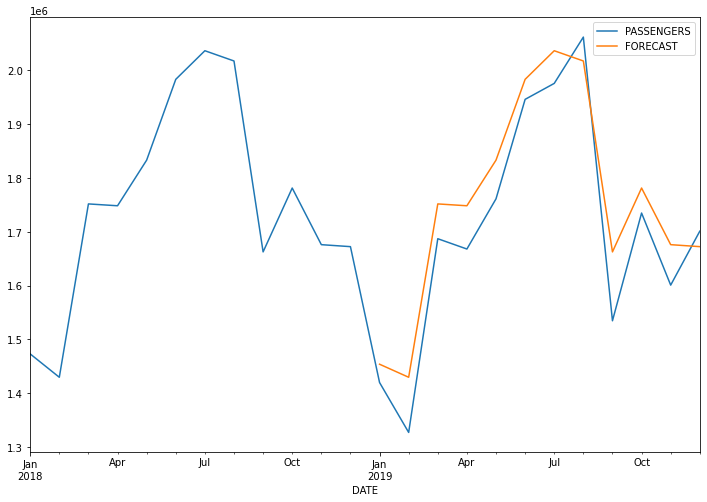

In [113]:
pass_sfo_19[['PASSENGERS','FORECAST']].iloc[-24:].plot(figsize = (12,8))

### 5. Evaluate the model

In [107]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test['PASSENGERS'],pass_sfo_19['FORECAST'].iloc[-12:])

In [109]:
print(f'SARIMA(0,0,1)(0,1,0,12) MSE Error: {error:9.8}')

SARIMA(0,0,1)(0,1,0,12) MSE Error: 4.9633471e+09


In [110]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['PASSENGERS'], pass_sfo_19['FORECAST'].iloc[-12:])
print(f'SARIMA(0,0,1)(0,1,0,12) RMSE Error: {error:11.10}')

SARIMA(0,0,1)(0,1,0,12) RMSE Error: 70451.02637


**From the root mean square error and the plot we notice the forecast does not capture the lowest month of the number of passengers in 2019, which is normal, since from the decomposition plot, we already notice the passengers were decreasing from 2019 compared to previous years.**